# Uncertainty for unseen categories

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version {tfp.__version__}")

TensorFlow version: 2.8.0
TensorFlow Probability version 0.16.0


In [2]:
# Load Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
print(X_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [4]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [5]:
len(X_train_full)

60000

In [6]:
y_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [7]:
# Create validation set and normalize data
valid_size = 10000
train_size = len(X_train_full)-valid_size
X_train, X_valid = ((X_train_full[:train_size]/255.)-0.5)*2, ((X_train_full[train_size:]/255.)-0.5)*2.
y_train, y_valid = y_train_full[:train_size], y_train_full[train_size:]
X_test = ((X_test/255.) - 0.5)*2

In [47]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

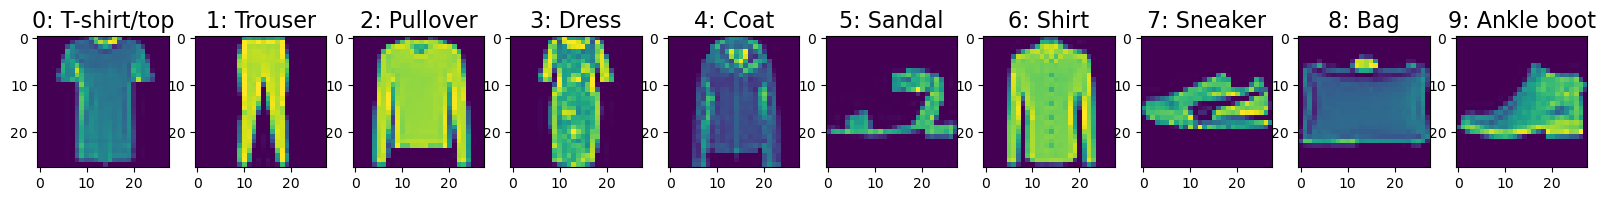

In [48]:
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rand=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rand]
    plt.imshow(img[0,:,:,])
    plt.title(str(y_train[rand][0])+ ": " +class_names[i],fontsize=16)

In [49]:
# Let's remove one class and make it "unknown"
unknown_class = 1
y_train_known = np.delete(y_train,np.where(y_train==unknown_class)[0])
X_train_known = np.delete(X_train,np.where(y_train==unknown_class)[0],axis=0)
y_valid_known = np.delete(y_valid,np.where(y_valid==unknown_class)[0])
X_valid_known = np.delete(X_valid,np.where(y_valid==unknown_class)[0],axis=0)
print(y_train_known.shape)
print(X_train_known.shape)
print(y_valid_known.shape)
print(X_valid_known.shape)

(44988,)
(44988, 28, 28)
(9012,)
(9012, 28, 28)


In [61]:
y_train_known_onehot = np.delete(keras.utils.to_categorical(y_train_known),1,axis=1)
y_valid_known_onehot = np.delete(keras.utils.to_categorical(y_valid_known),1,axis=1)

In [62]:
pd.Series(y_train_known).unique()

array([9, 0, 3, 2, 7, 5, 6, 4, 8], dtype=uint8)

In [64]:
y_train_known_onehot.shape

(44988, 9)

In [65]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model

class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Define model
input_ = Input(shape=(28,28,1))
x = Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'selu')(input_)
x = MCDropout((0.3))(x)
x = Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(32,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(64,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Convolution2D(128,kernel_size=(3,3),padding="same", activation = 'selu')(x)
x = MCDropout((0.3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(100, activation = 'selu')(x)
x = BatchNormalization()(x)
x = MCDropout((0.3))(x)
x = Dense(9, activation = 'softmax')(x)
model_mc = Model(inputs=[input_], outputs=[x])

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 mc_dropout_15 (MCDropout)   (None, 28, 28, 8)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 mc_dropout_16 (MCDropout)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                           

In [66]:
history_mc=model_mc.fit(X_train_known, y_train_known_onehot,
                        validation_data=(X_valid_known, y_valid_known_onehot),
                        batch_size=32,
                        epochs=100,
                        verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint("mc_dropout_model_no_trousers.h5", save_best_only=True)])

Epoch 1/100
1406/1406 [==============================] - 41s 28ms/step - loss: 0.7976 - accuracy: 0.7056 - val_loss: 0.5751 - val_accuracy: 0.7964
Epoch 2/100
1406/1406 [==============================] - 52s 37ms/step - loss: 0.5111 - accuracy: 0.8156 - val_loss: 0.4676 - val_accuracy: 0.8275
Epoch 3/100
1406/1406 [==============================] - 49s 35ms/step - loss: 0.4428 - accuracy: 0.8421 - val_loss: 0.4173 - val_accuracy: 0.8490
Epoch 4/100
1406/1406 [==============================] - 49s 35ms/step - loss: 0.4086 - accuracy: 0.8544 - val_loss: 0.3894 - val_accuracy: 0.8603
Epoch 5/100
1406/1406 [==============================] - 48s 34ms/step - loss: 0.3802 - accuracy: 0.8639 - val_loss: 0.3862 - val_accuracy: 0.8610
Epoch 6/100
1406/1406 [==============================] - 48s 34ms/step - loss: 0.3624 - accuracy: 0.8695 - val_loss: 0.3562 - val_accuracy: 0.8719
Epoch 7/100
1406/1406 [==============================] - 51s 36ms/step - loss: 0.3468 - accuracy: 0.8753 - val_loss: 0

In [69]:
df_hist = pd.DataFrame(history_mc.history)

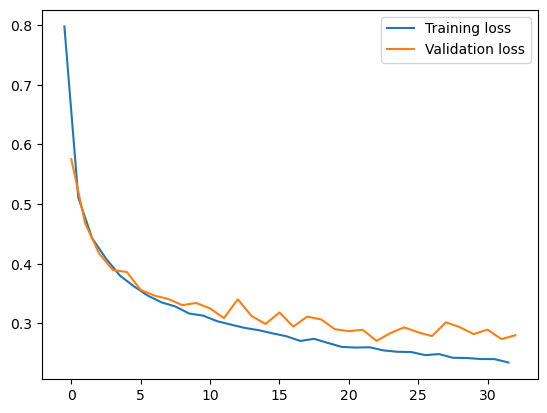

In [72]:
plt.plot(np.arange(len(df_hist.loss))-0.5, df_hist.loss, label="Training loss")
plt.plot(np.arange(len(df_hist.loss)), df_hist.val_loss, label="Validation loss")
plt.legend()

In [73]:
known_idx=np.where(y_test != unknown_class)[0]
unknown_idx=np.where(y_test == unknown_class)[0]

In [74]:
X_test_known = X_test[known_idx]
y_test_known = y_test[known_idx]

X_test_unknown = X_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

In [114]:
def add_zeros_for_missing_class(arr, labels, missing_index):
    out = np.zeros([arr.shape[0], arr.shape[1]+1])
    cols = [i for i in range(len(labels)) if i != missing_index]
    out[:,cols] = arr
    return out

In [101]:
out = np.zeros([p_pred_known.shape[0], p_pred_known.shape[1]+1])
cols = [i for i in range(len(class_names)) if i != unknown_class]
out[:,cols] = p_pred_known

In [124]:
p_pred_known = model_mc.predict(X_test_known)
p_pred = add_zeros_for_missing_class(p_pred_known, class_names, unknown_class)
y_pred_known = np.argmax(p_pred, axis=1)
(y_pred_known == y_test_known).mean()

0.8985555555555556

In [125]:
p_pred_all = model_mc.predict(X_test)
p_pred_all2 = add_zeros_for_missing_class(p_pred_all, class_names, unknown_class)
y_pred_all = np.argmax(p_pred_all2, axis=1)
(y_pred_all == y_test).mean()

0.8062

In [21]:
#n_reps = 100
#y_pred = np.zeros(len(X_test))
#for i in range(len(X_test)):
#    y_pred = model_mc.predict(np.tile(X_test[i], (n_reps,1,1))).mean(axis=0).argmax()
    

In [108]:
np.random.seed(123)
random_sample_known=np.random.choice(range(0,len(X_test_known)),1)
np.random.seed(456)
random_sample_unknown=np.random.choice(range(0,len(X_test_unknown)),1)

In [109]:
from copy import deepcopy
class_names_known = deepcopy(class_names)
class_names_known.remove(class_names[unknown_class])

(0.0, 1.0)

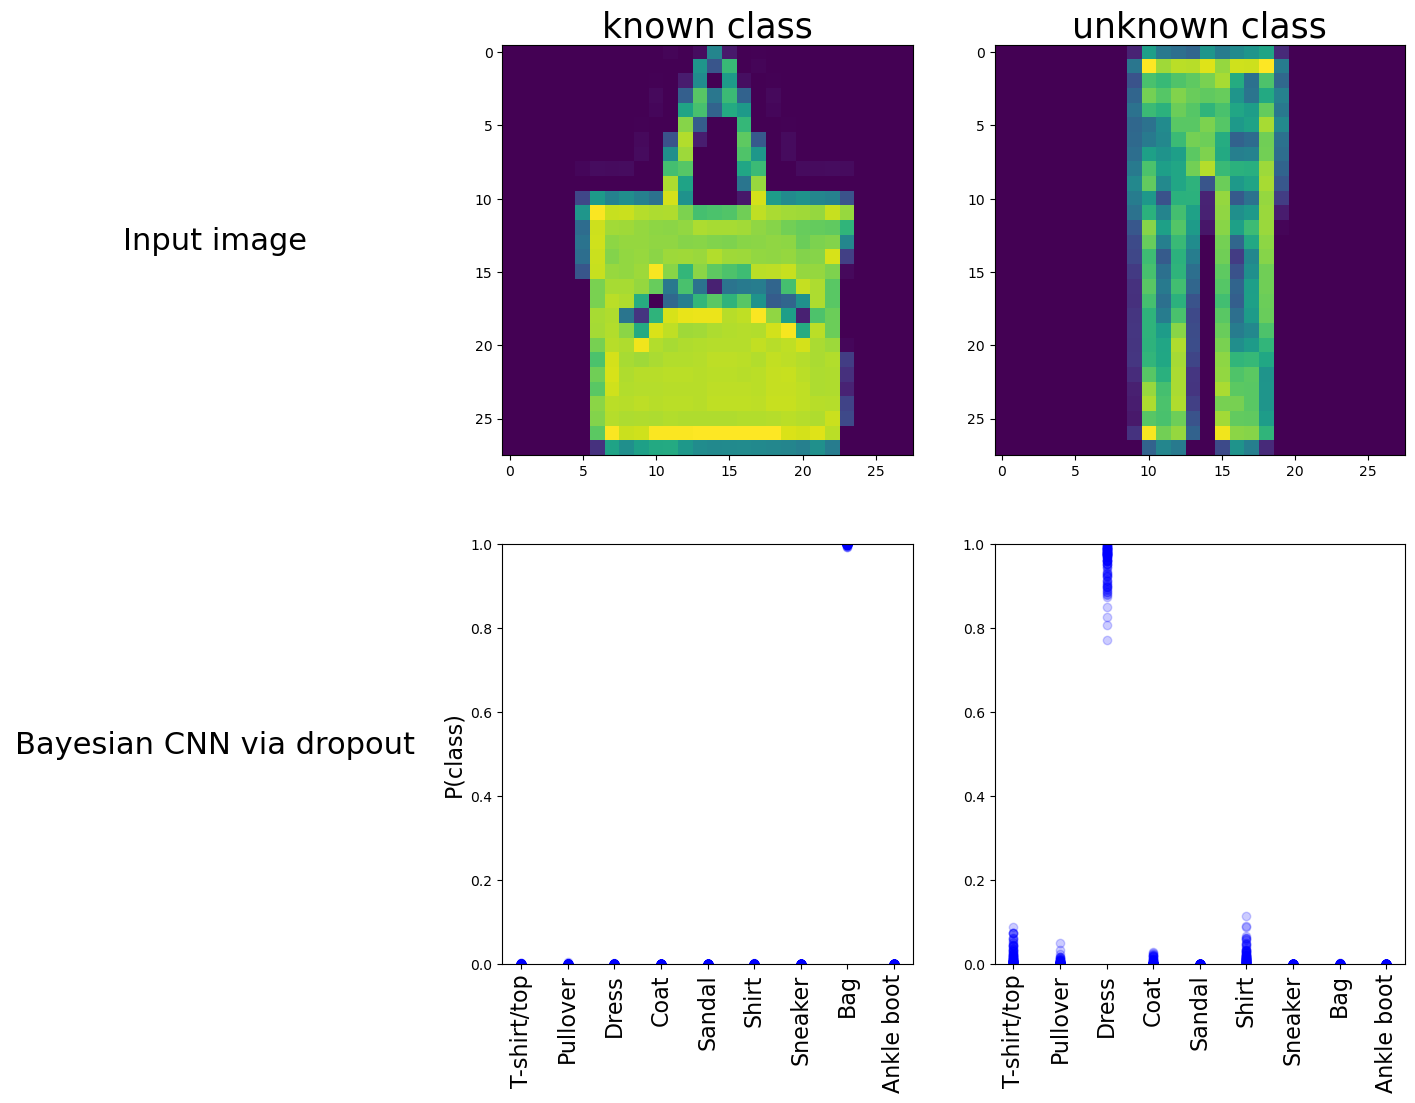

In [112]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(2,3,2)
plt.imshow(np.squeeze(np.array(((((X_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(2,3,3)
plt.imshow(np.squeeze(np.array(((((X_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(2,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')
plt.subplot(2,3,5)
for i in range(0,100):
  plt.scatter(range(0,9),model_mc.predict(X_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(2,3,6)
for i in range(0,100):
  plt.scatter(range(0,9),model_mc.predict(X_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=class_names_known,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])